In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner
from tqdm.auto import tqdm  # notebook friendly
import glob
import arviz as az

from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils
from agnfinder.tf_sampling import parameter_recovery, percentile_limits

In [4]:
os.chdir('/home/walml/repos/agnfinder')

In [5]:

# save_dir = 'results/emulated_sampling/real'
# save_dir = '/media/walml/beta/agnfinder_results/euclid_med_real_unc_fixed_z'
save_dir = 'results/emulated_sampling/30k_burnin'

all_galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')
assert all_galaxy_locs




1005 galaxies loaded [00:00, 5418.70 galaxies loaded/s]
243 galaxies loaded [00:04, 58.21 galaxies loaded/s] /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:116: RuntimeWarning:invalid value encountered in greater
1005 galaxies loaded [00:17, 57.97 galaxies loaded/s]
 /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:49: RuntimeWarning:invalid value encountered in true_divide


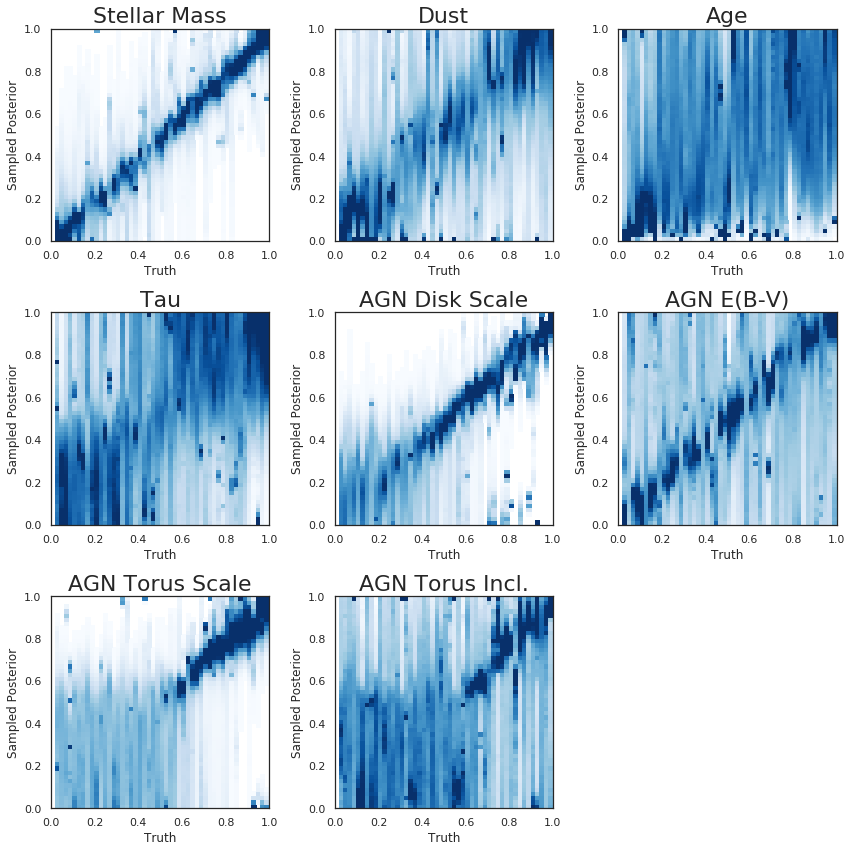

In [10]:
fig, axes = parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

In [18]:
min_acceptance = 0.6
max_redshift = 1.0
n_param_bins = 50
n_posterior_bins = 50  # or will have to remake marginals

In [170]:
params, marginals, true_params, samples = parameter_recovery.load_samples(save_dir, min_acceptance, max_redshift)
posterior_records, param_bins = parameter_recovery.get_all_posterior_records(marginals, true_params, n_param_bins=n_param_bins, n_posterior_bins=n_posterior_bins)

1005 galaxies loaded [00:00, 5977.88 galaxies loaded/s]
1005 galaxies loaded [00:18, 53.87 galaxies loaded/s]


In [23]:
posterior_records[0].shape

(50, 50)

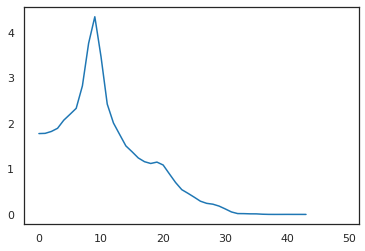

In [26]:
plt.plot(posterior_records[0][10])

In [60]:
posterior_record = posterior_records[0]
posterior = posterior_record[20]
param_values = np.arange(len(posterior))


In [40]:
import arviz as az

In [41]:
samples.shape

(755, 800, 8)

In [45]:
true_params[0, 0]

0.2713666558265686

In [42]:
az.hpd(samples[0, :, 0])

array([0.20375964, 0.35338613], dtype=float32)

In [ ]:
# group samples wit

In [180]:
dummy_array = np.zeros(42)  # anything
n_param_bins = 10
_, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=n_param_bins)
param_bins.shape

(11,)

In [181]:
bin_centers = param_bins[1:] + (param_bins[0:-1] - param_bins[1:]) / 2

In [182]:
bin_centers.shape

(10,)

In [186]:
samples.shape

(755, 3200, 8)

In [287]:
samples_by_truth = [[] for n in range(len(bin_centers))]

which_param = 0  # mass
for galaxy_n in range(len(samples)):
    true_param = true_params[galaxy_n, which_param]
    true_param_index = np.digitize(true_param, param_bins) - 1
#     print(true_param_index)
    samples_by_truth[true_param_index].append(np.squeeze(samples[galaxy_n, :, which_param]))
# samples_by_truth = np.array(samples_by_truth)

for n in range(len(samples_by_truth)):
    samples_by_truth[n] = np.array(samples_by_truth[n]).flatten()

In [288]:
az.hpd

<function arviz.stats.stats.hpd(ary, credible_interval=0.94, circular=False, multimodal=False)>

In [289]:
[x.shape for x in samples_by_truth]

[(345600,),
 (272000,),
 (262400,),
 (195200,),
 (201600,),
 (227200,),
 (208000,),
 (265600,),
 (233600,),
 (204800,)]

In [290]:
az.hpd(np.arange(1000))

array([  0, 940])

In [291]:
def get_hpd(x, ci=0.8):
    if len(x) == 0:
        return np.array([np.nan, np.nan])
    return az.hpd(x[~np.isnan(x)], credible_interval=ci)

In [292]:
bounds_by_truth = np.array([get_hpd(x) for x in samples_by_truth])
medians = np.array([np.median(x) for x in samples_by_truth])

In [300]:
# bounds_by_truth[:, 0]

In [301]:
# bounds_by_truth[:, 1] - bounds_by_truth[:, 0]

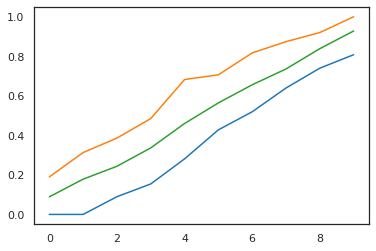

In [295]:
plt.plot(bounds_by_truth)
plt.plot(medians)

In [296]:
delta_bounds_by_truth = bounds_by_truth.copy().transpose()
delta_bounds_by_truth[1, :] = delta_bounds_by_truth[1, :] - medians
delta_bounds_by_truth[0, :] = medians - delta_bounds_by_truth[0, :]

In [277]:
# plt.plot(delta_bounds_by_truth.transpose())

<ErrorbarContainer object of 3 artists>

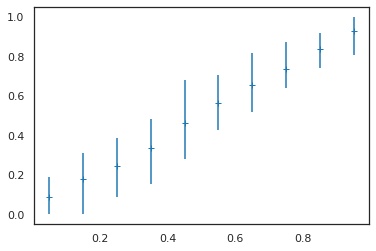

In [297]:
plt.errorbar(bin_centers, medians, yerr=delta_bounds_by_truth, linestyle='', marker='+')

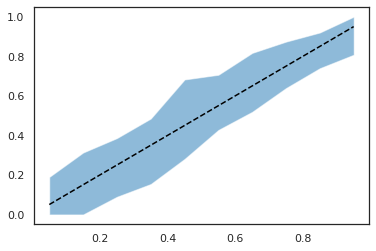

In [299]:
plt.fill_between(bin_centers, bounds_by_truth[:, 0], bounds_by_truth[:, 1], alpha=0.5)
plt.plot(bin_centers, bin_centers, linestyle='--', color='k')

In [280]:
def get_bounds(posterior, bin_centers, ci=0.9):
    missing = np.isnan(posterior)
    p = posterior[~missing]
#     param_values = param_values[~missing]
    centers = bin_centers[~missing]
    if len(centers) == 0:
        return np.array([np.nan, np.nan])
    samples = np.random.choice(centers, p=p/p.sum(), size=800000)
    return az.hpd(samples, credible_interval=ci)

In [109]:
bounds = np.array([get_bounds(posterior, bin_centers) for posterior in posterior_record])

In [110]:
bounds.shape

(50, 2)

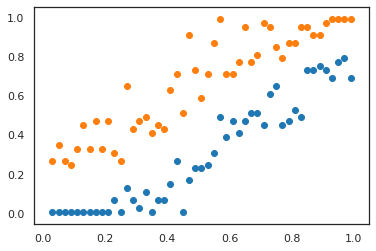

In [111]:
plt.scatter(bin_centers, bounds[:, 0])
plt.scatter(bin_centers, bounds[:, 1])